# Import and misc

In [1]:
!pip install torchaudio==0.9.1
!pip install thop

     |████████████████████████████████| 1.9 MB 4.8 MB/s 
     |████████████████████████████████| 831.4 MB 6.3 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [38]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

import os

In [3]:
import random
def set_seed(SEED = 777):
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    random.seed(SEED)

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [4]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [5]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-22 20:31:32--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.217.128, 2607:f8b0:400c:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.217.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   127MB/s    in 12s     

2021-11-22 20:31:44 (118 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [6]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [7]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [8]:
dataset.csv.sample(5)

,path,keyword,label
11344,speech_commands/three/5e3dde6b_nohash_1.wav,three,0
34888,speech_commands/two/5fe4a278_nohash_1.wav,two,0
12228,speech_commands/five/95ba4996_nohash_3.wav,five,0
35822,speech_commands/two/bbd0bbd0_nohash_3.wav,two,0
9033,speech_commands/left/ae927455_nohash_2.wav,left,0


### Augmentations

In [9]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [10]:
set_seed()
indexes = torch.randperm(len(dataset))
print(indexes[:5])
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

tensor([62005, 57280, 25038,  4203,  4490])


In [11]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [12]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [13]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [14]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [15]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [16]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [17]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [18]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [19]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [28]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [29]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [30]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [31]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [32]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

70443

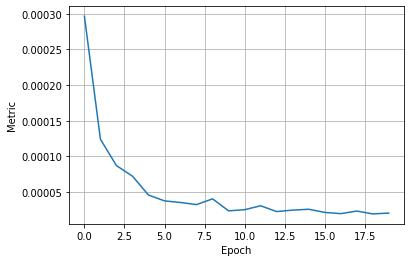

END OF EPOCH 19


In [ ]:
# TRAIN
set_seed()
for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0002964438936398027,
              0.00012391910929578315,
              8.695910335210576e-05,
              7.213571516059939e-05,
              4.5693511828649035e-05,
              3.7500068999768915e-05,
              3.524433601410489e-05,
              3.2284432413868524e-05,
              4.037045938628846e-05,
              2.3547942755106315e-05,
              2.514127795926582e-05,
              3.063738928147893e-05,
              2.2509589475991143e-05,
              2.4538555653572526e-05,
              2.5779805550445845e-05,
              2.1333982602510158e-05,
              1.960936135156598e-05,
              2.3261500471212476e-05,
              1.9227438306374188e-05,
              2.0385142537111805e-05]})

### Reproduce

In [ ]:
history = defaultdict(list)
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


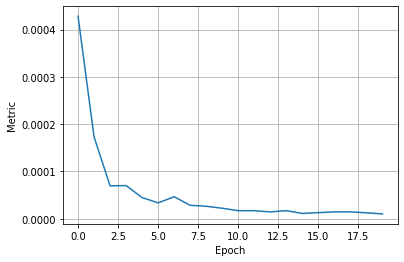

END OF EPOCH 19


In [ ]:
# TRAIN
set_seed()

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.00042809992837451017,
              0.0001729783179601848,
              6.943241610635125e-05,
              6.998739803139557e-05,
              4.4655158549533845e-05,
              3.341229890670053e-05,
              4.6338006967410185e-05,
              2.829811062967921e-05,
              2.625124180935446e-05,
              2.207992605015037e-05,
              1.6917997392480087e-05,
              1.6870257011831108e-05,
              1.4310179099529891e-05,
              1.696573777312906e-05,
              1.1028027929912943e-05,
              1.2770551823600488e-05,
              1.4345984385016621e-05,
              1.4381789670503351e-05,
              1.2406531421152061e-05,
              1.0067252769352346e-05]})

# Save basemodel

In [ ]:
torch.save(basemodel.state_dict(), 'basemodel_dict.pt')

In [ ]:
torch.save(model, 'basemodel_kws.pt')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build


drive_service = build('drive', 'v3')

file_metadata = {
  'name': 'basemodel_kws.pt'
}
media = MediaFileUpload('basemodel_kws.pt', 
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

In [ ]:
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build


drive_service = build('drive', 'v3')

file_metadata = {
  'name': 'basemodel_dict.pt'
}
media = MediaFileUpload('basemodel_dict.pt', 
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1onkpFrJDsrhYMUfOSFD8Evg9H7Q72jAf


# Download basemodel

In [25]:
!gdown --id 1i0J_K45Y0Ez6Biy18r8_6gmn4qy8nekB

Downloading...
From: https://drive.google.com/uc?id=1i0J_K45Y0Ez6Biy18r8_6gmn4qy8nekB
To: /content/basemodel_kws.pt
100% 288k/288k [00:00<00:00, 44.0MB/s]


In [26]:
!gdown --id 1onkpFrJDsrhYMUfOSFD8Evg9H7Q72jAf

Permission denied: https://drive.google.com/uc?id=1onkpFrJDsrhYMUfOSFD8Evg9H7Q72jAf
Maybe you need to change permission over 'Anyone with the link'?


In [33]:
if config.device.type == 'cpu':
    basemodel = torch.load('basemodel_kws.pt', map_location=torch.device('cpu')).to(config.device)
else:
    basemodel = torch.load('basemodel_kws.pt').to(config.device)

In [34]:
validation(basemodel, val_loader, melspec_val, config.device)

102it [00:11,  8.56it/s]


1.101012528716958e-05

# Metrics

In [20]:
from thop import profile  # !pip install thop

In [21]:
def get_size_in_megabytes(model):
    num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    param_size = next(model.parameters()).element_size()
    return (num_params * param_size) / (2 ** 20)

In [22]:
def size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    # print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [23]:
def get_metrics(model, basemodel, verbose=False):
    model_profile = profile(model, (torch.randn(128, 40, 101).to(config.device), ))  # -> (6.0 MACs, 3.0 parameters)
    base_profile = profile(basemodel, (torch.randn(128, 40, 101).to(config.device), ))  # -> (6.0 MACs, 3.0 parameters)
    if verbose:
        print("Base model profile :", base_profile)
        print("Model profile :", model_profile)
    print("Speed up rate :", base_profile[0] / model_profile[0])
    basemodel_size = size_of_model(basemodel)
    model_size = size_of_model(model)
    if verbose:
        print("Base model size :", basemodel_size)
        print("Model size :", model_size)
    print("Compression rate :", basemodel_size / model_size)

In [39]:
get_metrics(basemodel, basemodel, True)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequ

# Streaming 

In [ ]:
class CRNN_streaming(nn.Module):
    '''
    Yields predictions in streaming mode
    You may forward any duration into streaming mode
    You should treat prediction as actual until next yielding
    '''
    def __init__(self, config: TaskConfig, max_window_length=52):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
        
        #streaming eval
        self.max_window_length = max_window_length
        # kernel_size + stride * (gru_outputs_length - 1) = max_window_length
        self.gru_outputs_length = ((max_window_length - config.kernel_size[-1]) / config.stride[-1]) + 1
        self.conv_input = []
        self.gru_outputs = []
        self.skip_by_stride = 0
        self.prev_hidden = None
    
    def reset_stream(self):
        self.conv_input = []
        self.gru_outputs = []
        self.skip_by_stride = 0
        self.prev_hidden = None

    def forward(self, input):
        if self.training:
            input = input.unsqueeze(dim=1)
            conv_output = self.conv(input).transpose(-1, -2)
            gru_output, _ = self.gru(conv_output)
            contex_vector = self.attention(gru_output)
            output = self.classifier(contex_vector)
            return output
        else:
            for index in range(input.shape[-1]):
                self.conv_input.append(input[:, :, index])
                if len(self.conv_input) < self.config.kernel_size[-1]:
                    continue
                if len(self.conv_input) > self.config.kernel_size[-1]:
                    self.conv_input.pop(0)
                if self.skip_by_stride != 0:
                    self.skip_by_stride -= 1
                    continue
                self.skip_by_stride = self.config.stride[-1] - 1
                conv_frame = torch.permute(torch.stack(self.conv_input), (1, 2, 0)).unsqueeze(1)
                conv_output = self.conv(conv_frame).transpose(-1, -2)
                if self.prev_hidden is not None:
                    gru_output, self.prev_hidden = self.gru(conv_output, self.prev_hidden)
                else:
                    gru_output, self.prev_hidden = self.gru(conv_output)
                self.gru_outputs.append(gru_output.squeeze(1))
                if len(self.gru_outputs) < self.gru_outputs_length:
                    continue
                if len(self.gru_outputs) > self.gru_outputs_length:
                    self.gru_outputs.pop(0)
                attention_input = torch.stack(self.gru_outputs).permute(1, 0, 2)
                contex_vector = self.attention(attention_input)
                output = self.classifier(contex_vector)
                yield output


In [ ]:
samples, labels = next(iter(val_loader))
labels

tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
indexes = [3, 0, 1]
streaming_sample = samples[indexes, :].view(-1)

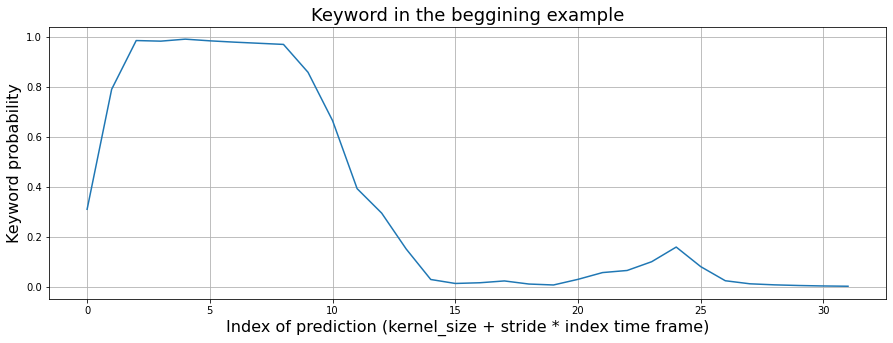

In [ ]:
set_seed()
config = TaskConfig()
model = CRNN_streaming(config)
model.load_state_dict(torch.load('basemodel_dict.pt'), strict=False)
model.eval()
keyword_probability = []
for logits in model.forward(melspec_train(streaming_sample).unsqueeze(0)):
    probs = F.softmax(logits, dim=-1)
    keyword_probability.append(probs[0, 1].item())

plt.figure(figsize=(15, 5))
plt.title("Keyword in the beggining example", fontsize=18)
plt.xlabel("Index of prediction (kernel_size + stride * index time frame)", fontsize=16)
plt.ylabel("Keyword probability", fontsize=16)
plt.plot(keyword_probability)
plt.grid()
plt.show()

In [ ]:
indexes = [0, 3, 1]
streaming_sample = samples[indexes, :].view(-1)

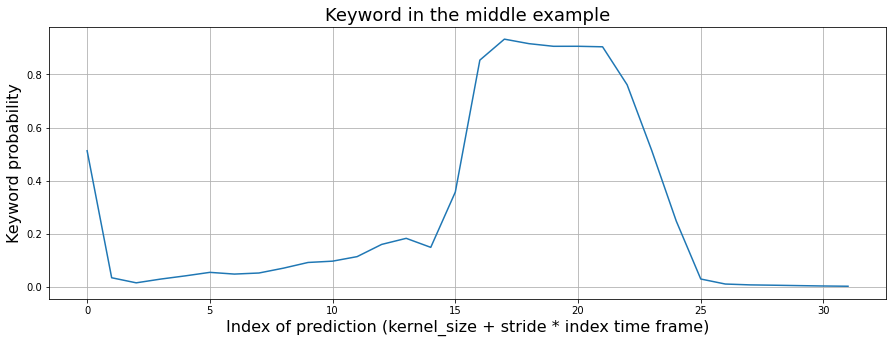

In [ ]:
set_seed()
config = TaskConfig()
model = CRNN_streaming(config)
model.load_state_dict(torch.load('basemodel_dict.pt'), strict=False)
model.eval()
keyword_probability = []
for logits in model.forward(melspec_train(streaming_sample).unsqueeze(0)):
    probs = F.softmax(logits, dim=-1)
    keyword_probability.append(probs[0, 1].item())

plt.figure(figsize=(15, 5))
plt.title("Keyword in the middle example", fontsize=18)
plt.xlabel("Index of prediction (kernel_size + stride * index time frame)", fontsize=16)
plt.ylabel("Keyword probability", fontsize=16)
plt.plot(keyword_probability)
plt.grid()
plt.show()

In [ ]:
indexes = [0, 1, 3]
streaming_sample = samples[indexes, :].view(-1)

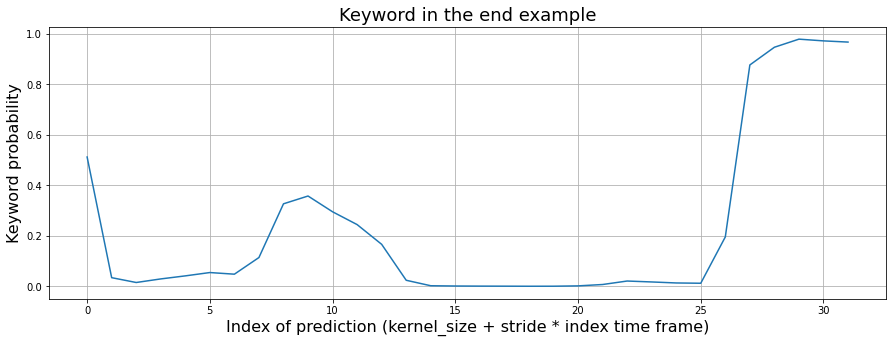

In [ ]:
set_seed()
config = TaskConfig()
model = CRNN_streaming(config)
model.load_state_dict(torch.load('basemodel_dict.pt'), strict=False)
model.eval()
keyword_probability = []
for logits in model.forward(melspec_train(streaming_sample).unsqueeze(0)):
    probs = F.softmax(logits, dim=-1)
    keyword_probability.append(probs[0, 1].item())

plt.figure(figsize=(15, 5))
plt.title("Keyword in the end example", fontsize=18)
plt.xlabel("Index of prediction (kernel_size + stride * index time frame)", fontsize=16)
plt.ylabel("Keyword probability", fontsize=16)
plt.plot(keyword_probability)
plt.grid()
plt.show()

# Experiments

## I. qint8

In [ ]:
quantized_model_from_base = torch.quantization.quantize_dynamic(basemodel, {torch.nn.Linear, torch.nn.GRU}, dtype=torch.qint8)
validation(quantized_model_from_base, val_loader, melspec_val, config.device)

102it [00:12,  8.38it/s]


1.1451723808172587e-05

In [ ]:
get_metrics(quantized_model_from_base, basemodel)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

## II. Dark Knowledge Distillation

### Training

https://arxiv.org/pdf/1503.02531.pdf

Since the magnitudes of the gradients produced by the soft targets scale as $1/T^2$
it is important to multiply them by $T^2$ when using both hard and soft targets. This ensures that the
relative contributions of the hard and soft targets remain roughly unchanged if the temperature used
for distillation is changed while experimenting with meta-parameters.

In [ ]:
def train_epoch_distillation(model, teacher_model, opt, loader, log_melspec, device, T = 5, alpha = 0.5):
    model.train()
    teacher_model.eval()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        with torch.no_grad():
            teacher_logits = teacher_model(batch)
        # we need probabilities so we use softmax & CE separately
        probs_hard = F.softmax(logits, dim=-1)
        probs_soft = F.softmax(logits / T, dim=-1)
        teacher_probs_soft = F.softmax(teacher_logits / T, dim=-1)
        
        loss = (alpha * T * T) * F.cross_entropy(logits, labels) + (1 - alpha) * F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs_hard, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

### Distillation experiments

#### 1. cnn_out_channels=4, hidden_size=32, gru_num_layers=2

In [ ]:
history = defaultdict(list)
config = TaskConfig(cnn_out_channels=4, hidden_size=32, gru_num_layers=2)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
get_metrics(model, basemodel, True)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequ

Current validation metric : 3.565012924962117e-05


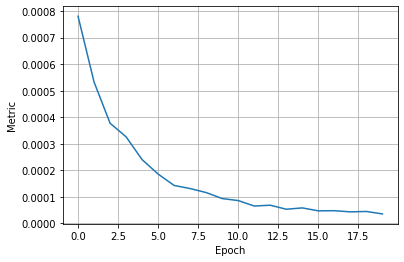

END OF EPOCH 19


In [ ]:
# TRAIN
set_seed()

for n in range(TaskConfig.num_epochs):

    train_epoch_distillation(model, basemodel, opt, train_loader, melspec_train, config.device, T=5, alpha=0.1)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    print(f'Current validation metric : {au_fa_fr}')
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

#### 2. cnn_out_channels=4, hidden_size=32, gru_num_layers=1


In [ ]:
history = defaultdict(list)
config = TaskConfig(cnn_out_channels=4, hidden_size=32, gru_num_layers=1)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 32, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
get_metrics(model, basemodel, True)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequ

Current validation metric : 2.591109159723052e-05


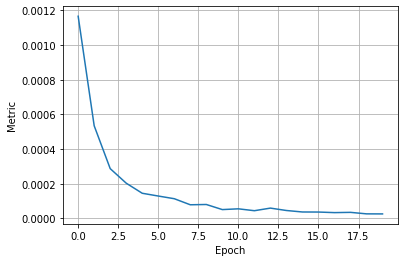

END OF EPOCH 19


In [ ]:
# TRAIN
set_seed()

for n in range(TaskConfig.num_epochs):

    train_epoch_distillation(model, basemodel, opt, train_loader, melspec_train, config.device, T=5, alpha=0.1)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    print(f'Current validation metric : {au_fa_fr}')
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

#### 3. cnn_out_channels=1, hidden_size=32, gru_num_layers=1

In [36]:
history = defaultdict(list)
config = TaskConfig(cnn_out_channels=1, hidden_size=32, gru_num_layers=1)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 1, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(18, 32, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [40]:
get_metrics(model, basemodel, True)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequ

Current validation metric : 4.5860603160920445e-05


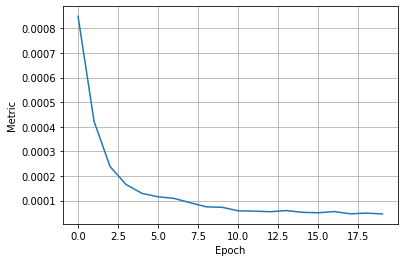

END OF EPOCH 19


In [ ]:
# TRAIN
set_seed()

for n in range(TaskConfig.num_epochs):

    train_epoch_distillation(model, basemodel, opt, train_loader, melspec_train, config.device, T=5, alpha=0.1)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    print(f'Current validation metric : {au_fa_fr}')
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 1, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(18, 32, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

#### Save compressed model

In [ ]:
torch.save(model, 'compressed_model_kws.pt')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build


drive_service = build('drive', 'v3')

file_metadata = {
  'name': 'compressed_model_kws.pt'
}
media = MediaFileUpload('compressed_model_kws.pt', 
                        resumable=True)
created = drive_service.files().create(body=file_metadata,
                                       media_body=media,
                                       fields='id').execute()
print('File ID: {}'.format(created.get('id')))

File ID: 1UhZ0a44Gw5T2Zi2hu47KwfqF8DuhN5fg


## Download compressed model

In [41]:
!gdown --id 1UhZ0a44Gw5T2Zi2hu47KwfqF8DuhN5fg

Downloading...
From: https://drive.google.com/uc?id=1UhZ0a44Gw5T2Zi2hu47KwfqF8DuhN5fg
To: /content/compressed_model_kws.pt
100% 34.4k/34.4k [00:00<00:00, 33.3MB/s]


In [42]:
if config.device.type == 'cpu':
    compressed_model = torch.load('compressed_model_kws.pt', map_location=torch.device('cpu')).to(config.device)
else:
    compressed_model = torch.load('compressed_model_kws.pt').to(config.device)

In [43]:
get_metrics(compressed_model, basemodel)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequ

In [ ]:
validation(compressed_model, val_loader, melspec_val, config.device)

102it [00:11,  8.69it/s]


4.541303709233631e-05

## III. Dark Knowledge Distillation + qint8

In [44]:
quantized_model = torch.quantization.quantize_dynamic(compressed_model, {torch.nn.Linear, torch.nn.GRU}, dtype=torch.qint8)

/usr/local/lib/python3.7/dist-packages/torch/nn/quantized/dynamic/modules/rnn.py:64: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [45]:
validation(quantized_model, val_loader, melspec_val, config.device)

102it [00:12,  8.03it/s]


4.988869777817761e-05

In [46]:
get_metrics(quantized_model, basemodel)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

## IV. Dark Knowledge Distillation + fp16

In [ ]:
quantized_fp16_model = torch.quantization.quantize_dynamic(compressed_model, {torch.nn.Linear, torch.nn.GRU}, dtype=torch.float16)

/usr/local/lib/python3.7/dist-packages/torch/nn/quantized/dynamic/modules/rnn.py:64: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
validation(quantized_fp16_model, val_loader, melspec_val, config.device)

102it [00:11,  8.72it/s]


4.540706954475519e-05

In [ ]:
get_metrics(quantized_fp16_model, basemodel)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>